# Jack’s Car Rental problem

In [1]:
import jax
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt
from jax import random
from functools import partial
# from jax.experimental import loops
from jax.scipy.stats import poisson

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

jnp.set_printoptions(suppress=True, linewidth=100)

Let
* $s_t^{(x)}$ be the number of cars at the end of day $t$,
* $\phi_t^{(x)}$ be the number of cars return to location $x$ at time $t$,
* $\varphi_t^{(x)}$ be the number of cars requested at location $x$ at time $t$, and
* $k_a \in \{-5, -4, \ldots, 4, 5\}$ be the number of cars moved from location $a$ to location $b$

## Location update
The state in location $a$ at end of day $t+1$, having moved $k_a$ cars overnight is
$$
\begin{aligned}
    s_{t+1}^{(a)'} &= s_t^{(a)} - k_a \\
    s_{t+1}^{(a)''} &= s_{t+1}^{(a)'} - \min\left(s_t^{(a)'}, \varphi_t^{(a)}\right) + \phi_t^{(a)}\\
    s_{t+1}^{(a)} &= \min\left( s_{t+1}^{(a)''}, 20 \right)
\end{aligned}
$$
We can rewrite the expression above as
$$
    s_{t+1}^{(a)} = \text{clip}\left(s_t^{(a)} - k_a - \varphi_t^{(a)} + \phi_t^{(a)}, \phi_t^{(a)}, 20\right)
$$
where $\text{clip}(x, u, v) = \min(\max(x, 0) + u, v)$ — $u$ is the lower bound and $v$ is the upper bound.


Similarly for location $b$, we have
$$
    s_{t+1}^{(b)} = \text{clip}\left(s_{t}^{(b)} + k_a - \varphi_t^{(b)} + \phi_t^{(b)}, \phi_t^{(b)}, 20\right)
$$

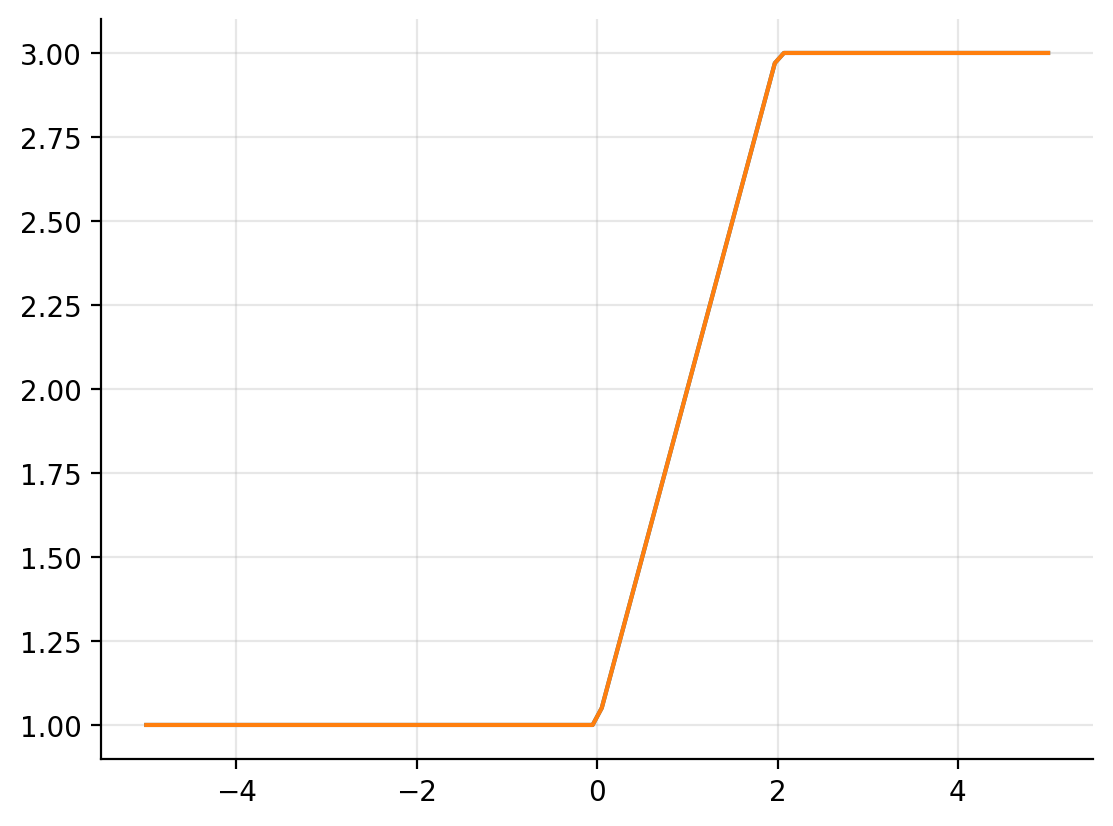

In [3]:
xv = jnp.linspace(-5, 5, 100)

def f(x, a, b):
    return jnp.minimum(jnp.maximum(x, a), b)
    
def fprime(x, a, b):
    return jnp.clip(x + a, a, b)
    
plt.plot(xv, f(xv + 1, 1, 3))
plt.plot(xv, fprime(xv, 1, 3))
plt.grid(alpha=0.3)

In [4]:
# Discount rate
γ = 0.9
# Rate of request
λ_req_a, λ_req_b = 3, 4
# Rate of return
λ_ret_a, λ_ret_b = 3, 2

# Maximum number of cars allowed at any location
max_cars = 20
# Maximum number of cars that are allowed to be moved overnight
max_car_move = 5

# MDP:
# timestep: days
# state: number of cars at each location at the end of the day
# actions: net number of cars moved between the two locations overnight

In [5]:
def update_location_a(s_prev, n_ret, n_req, k):
    """
    State in location a at the end of day t+1
    having moved k cars overnight from location a to location b
    """
    s_next = s_prev - k - n_req + n_ret
    s_next = jnp.clip(s_next + n_ret, n_ret, n_max)
    return s_next


def update_location_b(s_prev, n_ret, n_req, k):
    """
    State in location b at the end of day t+1
    having moved k cars overnight from location a to location b
    """
    s_next = s_prev + k - n_req + n_ret
    s_next = jnp.clip(s_next + n_ret, n_ret, n_max)
    return s_next


def pr_transition_a(n_ret, n_req):
    """
    Probability of transition at location a
    is given by the probability of returns
    times the probability of requests
    """
    p_ret = poisson.pmf(n_ret,  λ_ret_a)
    p_req = poisson.pmf(n_req, λ_req_a)
    return p_ret * p_req


def pr_transition_b(n_ret, n_req):
    p_ret = poisson.pmf(n_ret, λ_ret_b)
    p_req = poisson.pmf(n_req, λ_req_b)
    return p_ret * p_req

In [6]:
@partial(jax.vmap, in_axes=(None, None, 0, None, None, None, None, None))
@partial(jax.vmap, in_axes=(None, None, None, 0, None, None, None, None))
@partial(jax.vmap, in_axes=(None, None, None, None, 0, None, None, None))
@partial(jax.vmap, in_axes=(None, None, None, None, None, 0, None, None))
def prob_val_state(
    n_a,
    n_b,
    n_ret_a,
    n_ret_b,
    n_req_a,
    n_req_b,
    action,
    value_function
):
    """
    Element of (proba x value) used to evaluate the value function of a policy
    
    Params
    ------
    n_a: number of cars at location a (start of day)
    n_ret_a: number of cars returns to location a (end of day)
    n_req_a: number of cars requested at location a (during day)
    
    n_b: number of cars at location b (start of day)
    n_ret_b: number of cars returned to location b (end of day)
    n_req_b: number of cars requested at location b
    
    action: number of cars moved from a to b overnight
    """
    
    n_a_prime = jnp.clip(n_a - action - n_req_a + 2 * n_ret_a, n_ret_a, max_cars)
    n_b_prime = jnp.clip(n_b + action - n_req_b + 2 * n_ret_b, n_ret_b, max_cars)
    
    pr_a = pr_transition_a(n_ret_a, n_req_a)
    pr_b = pr_transition_b(n_ret_b, n_req_b)
    
    return pr_a * pr_b * (10 * (n_req_a + n_req_b) - 2 * jnp.abs(action) + γ * value_function[n_a_prime, n_b_prime])


def action_value_function(n_a, n_b, value_function, action):
    elements = jnp.arange(max_cars)
    probs_vals = prob_val_state(
        n_a, n_b,
        elements, elements, elements, elements,
        action, value_function
    ).sum()
    return probs_vals


# @jax.jit
def value_function(n_a, n_b, value_function, policy):
    policy_cond = policy[:, n_a, n_b]
    action = policy_cond.argmax() - max_car_move
    
    return action_value_function(n_a, n_b, value_function, action)

In [7]:
value_grid = jnp.zeros((max_cars + 1, max_cars + 1))
policy = jnp.zeros((2 * max_car_move + 1, max_cars + 1, max_cars + 1))
# Start by moving no cars at all
n_move = 0 # can take -5 to 5 value
policy = policy.at[n_move + max_car_move].set(1)


In [8]:
%%time
value_function(10, 10, value_grid, policy)

CPU times: user 2.87 s, sys: 49.8 ms, total: 2.92 s
Wall time: 2.21 s


Array(70.01568, dtype=float32)

In [9]:
xvalue_function = jax.vmap(value_function, in_axes=(0, None, None, None))
xvalue_function = jax.vmap(xvalue_function, in_axes=(None, 0, None, None))
xvalue_function = jax.jit(xvalue_function)

xaction_value_function = jax.vmap(action_value_function, in_axes=(None, None, None, 0))
xaction_value_function = jax.vmap(xaction_value_function, in_axes=(0, None, None, None))
xaction_value_function = jax.vmap(xaction_value_function, in_axes=(None, 0, None, None))
xaction_value_function = jax.jit(xaction_value_function)

In [10]:
%%time
states = jnp.arange(max_cars + 1)
actions = jnp.arange(2 * max_car_move + 1) - max_car_move
values = xvalue_function(states, states, value_grid, policy)

CPU times: user 3.37 s, sys: 0 ns, total: 3.37 s
Wall time: 1.47 s


In [11]:
@jax.jit
def new_policy(n_a, n_b, value_function, action):
    return xaction_value_function(states, states, values, actions).argmax(axis=0)

new_policy(states, states, values, actions).shape

XlaRuntimeError: RESOURCE_EXHAUSTED: XLA:TPU compile permanent error. Ran out of memory in memory space hbm. Used 27.99G of 15.48G hbm. Exceeded hbm capacity by 12.51G.

Total hbm usage >= 28.51G:
    reserved        530.00M 
    program          27.99G 
    arguments            0B 

Output size 0B; shares 0B with arguments.

Program hbm requirement 27.99G:
    global            52.0K
    HLO temp         27.99G (23.0% utilization: Unpadded (5.78G) Padded (25.10G), 10.3% fragmentation (2.89G))

  Largest program allocations in hbm:

  1. Size: 22.21G
     Operator: op_name="jit(new_policy)/jit(main)/jit(action_value_function)/mul" source_file="/tmp/ipykernel_2608541/2277767169.py" source_line=37
     Shape: f32[21,21,11,20,20,20,20]{6,5,4,3,2,1,0:T(8,128)}
     Unpadded size: 2.89G
     Extra memory due to padding: 19.31G (7.7x expansion)
     XLA label: reshape.523.remat2 = reshape(fusion.3)
     Allocation type: HLO temp
     ==========================

  2. Size: 2.89G
     Operator: op_name="jit(new_policy)/jit(main)/jit(action_value_function)/mul" source_file="/tmp/ipykernel_2608541/2277767169.py" source_line=37
     Shape: f32[776160000]{0:T(1024)}
     Unpadded size: 2.89G
     Extra memory due to padding: 1.0K (1.0x expansion)
     XLA label: fusion.3 = fusion(fusion), kind=kLoop, calls=fused_computation.3
     Allocation type: HLO temp
     ==========================

  3. Size: 4.69M
     Operator: op_name="jit(new_policy)/jit(main)/jit(action_value_function)/mul" source_file="/tmp/ipykernel_2608541/2277767169.py" source_line=37
     Shape: f32[20,20,20,20]{3,2,1,0:T(8,128)}
     Unpadded size: 625.0K
     Extra memory due to padding: 4.08M (7.7x expansion)
     XLA label: fusion.14 = fusion(fusion.23, fusion.24), kind=kLoop, calls=fused_computation.14
     Allocation type: HLO temp
     ==========================

  4. Size: 132.0K
     Operator: op_name="jit(new_policy)/jit(main)/jit(action_value_function)/convert_element_type[new_dtype=float32 weak_type=False]" source_file="/tmp/ipykernel_2608541/2277767169.py" source_line=37
     Shape: f32[11,20,20]{2,1,0:T(8,128)}
     Unpadded size: 17.2K
     Extra memory due to padding: 114.8K (7.7x expansion)
     XLA label: fusion.17 = fusion(constant.61, fusion.22), kind=kLoop, calls=fused_computation.17
     Allocation type: HLO temp
     ==========================

  5. Size: 4.0K
     Shape: u32[8,128]{1,0}
     Unpadded size: 4.0K
     XLA label: constant literal
     Allocation type: global
     ==========================

  6. Size: 1.0K
     Operator: op_name="jit(new_policy)/jit(main)/reduce[computation=<function _compute_argminmax.<locals>.reducer_fn at 0x7f4fe3228dc0> consts=() dimensions=(0,)]" source_file="/tmp/ipykernel_2608541/1386239514.py" source_line=3
     Shape: (bf16[21,11]{0,1:T(8,128)(2,1)}, s32[21,11]{0,1:T(8,128)})
     Unpadded size: 1.0K
     XLA label: fusion.18 = fusion(copy.3), kind=kLoop, calls=fused_computation.18
     Allocation type: HLO temp
     ==========================

  7. Size: 1.0K
     Operator: op_name="jit(new_policy)/jit(main)/jit(action_value_function)/exp" source_file="/tmp/ipykernel_2608541/1619180500.py" source_line=33
     Shape: (f32[20]{0:T(256)}, f32[20]{0:T(256)})
     Unpadded size: 1.0K
     XLA label: fusion.51 = fusion(get-tuple-element.2), kind=kLoop, calls=fused_computation.51
     Allocation type: HLO temp
     ==========================

  8. Size: 1.0K
     Operator: op_name="jit(new_policy)/jit(main)/jit(action_value_function)/exp" source_file="/tmp/ipykernel_2608541/1619180500.py" source_line=27
     Shape: (f32[20]{0:T(256)}, f32[20]{0:T(256)})
     Unpadded size: 1.0K
     XLA label: fusion.50 = fusion(), kind=kLoop, calls=fused_computation.50
     Allocation type: HLO temp
     ==========================

  9. Size: 1.0K
     Shape: (s32[21,11,20,20]{3,2,1,0:T(8,128)}, s32[21,11,20,20]{3,2,1,0:T(8,128)})
     Unpadded size: 1.0K
     XLA label: fusion.7 = fusion(fusion.68, fusion.16, fusion.15), kind=kLoop, calls=fused_computation.7
     Allocation type: HLO temp
     ==========================

  10. Size: 1.0K
     Shape: s32[11]{0:T(256)}
     Unpadded size: 44B
     Extra memory due to padding: 980B (23.3x expansion)
     XLA label: constant literal
     Allocation type: global
     ==========================

  11. Size: 1.0K
     Shape: s32[11]{0:T(256)}
     Unpadded size: 44B
     Extra memory due to padding: 980B (23.3x expansion)
     XLA label: constant literal
     Allocation type: global
     ==========================

  12. Size: 1.0K
     Shape: s32[11]{0:T(256)}
     Unpadded size: 44B
     Extra memory due to padding: 980B (23.3x expansion)
     XLA label: constant literal
     Allocation type: global
     ==========================



## Old stuff

In [40]:
value_grid = jnp.zeros((max_cars + 1, max_cars + 1))
policy = jnp.zeros((2 * max_car_move + 1, max_cars + 1, max_cars + 1))

# Start with moving no cars
n_move = 0 + 5
policy = policy.at[5].set(1)


In [5]:
max_elements = 20
discount = 0.9

@jax.jit
def value_function(state, action_array, value_grid, discount):
    state_a, state_b = state
    action = action_array.argmax() - 5
    
    action_clipped = jnp.clip(action, -state_b, state_a)
    is_valid_action = action == action_clipped
    
    with loops.Scope() as s:
        # cost of moving cars overnight
        s.expected_reward = -2.0 * jnp.abs(action)
        
        for n_ret_a in s.range(max_elements):
            for n_req_a in s.range(max_elements):
                for n_ret_b in s.range(max_elements):
                    for n_req_b in s.range(max_elements):
                        
                        pr = pr_transition_a(n_ret_a, n_req_a) * pr_transition_b(n_ret_b, n_req_b)
                                                
                        sa_prime = state_a - action
                        sb_prime = state_b + action
                        
                        n_req_a = jnp.minimum(sa_prime, n_req_a)
                        n_req_b = jnp.minimum(sb_prime, n_req_b)
                                                
                        sa_prime = sa_prime + n_ret_a - n_req_a
                        sb_prime = sb_prime + n_ret_b - n_req_b
                        
                        sa_prime = jnp.clip(sa_prime, 0, 20)
                        sb_prime = jnp.clip(sb_prime, 0, 20)

                        reward = 10.0 * (n_req_a + n_req_b)
                            
                        value_config = reward + discount * value_grid[sa_prime, sb_prime]
                        s.expected_reward += pr * value_config
                        
    return s.expected_reward * is_valid_action

In [6]:
vmap_value_function = jax.vmap(value_function, (1, 1, None, None), out_axes=0)
vmap_value_function = jax.vmap(vmap_value_function, (2, 2, None, None), out_axes=1)

In [7]:
improv_value_function = jax.vmap(value_function, (1, None, None, None), out_axes=0)
improv_value_function = jax.vmap(improv_value_function, (2, None, None, None), out_axes=1)
improv_value_function = jax.vmap(improv_value_function, (None, 0, None, None), out_axes=2)

## Iteration

In [8]:
# ** Initial policy **
# In the initial policy we assume that we will not be moving
# cars between lots
policy = jnp.zeros((11, 21, 21)) # (action, sa, sb)
policy = policy.at[5].set(1)
value_array = jnp.zeros((21, 21))
vrange = jnp.mgrid[:21, :21]
discount = 0.9
arange_ix = jnp.eye(11).astype(int) # Fixed array to pass to the policy-improvement scheme

In [9]:
@jax.jit
def update(value_array, policy, discount, max_err=0.1, eps=1e-6):
    with loops.Scope() as s:
        s.value_array = value_array
        s.err = max_err + 1.0
        s.ix = 0
        for _ in s.while_range(lambda: s.err > max_err):
            update_value_array = vmap_value_function(vrange, policy, s.value_array, discount)
            s.err = jnp.abs(update_value_array / (s.value_array + eps) - 1).max()
            s.value_array = update_value_array
            s.ix += 1
    return s.ix, s.value_array

In [10]:
threshold = 0.95
value_array = jnp.zeros((21, 21))
policy_ix = jnp.zeros((21, 21))
policy_hist = []

In [11]:
ix = 0
is_stable = False
policy_hist_ix = []
threshold = 0.95

while not is_stable:
    print(f"it: {ix+1:02}")
    nsteps, value_array = update(value_array, policy, discount)
    q_improv = improv_value_function(vrange, arange_ix, value_array, discount).block_until_ready()
    curr_threshold = (policy_ix == q_improv.argmax(axis=-1)).mean().item()
    is_stable = curr_threshold >= threshold
    policy_ix = q_improv.argmax(axis=-1)
    policy = jnp.transpose(jax.nn.one_hot(policy_ix, 11), (2, 0, 1))
    print(f"threshold: {curr_threshold:0.2%}", end="\n\n")
    policy_hist_ix.append(policy_ix)
    ix += 1

it: 01
threshold: 0.00%

it: 02
threshold: 38.78%

it: 03
threshold: 87.76%

it: 04
threshold: 97.73%



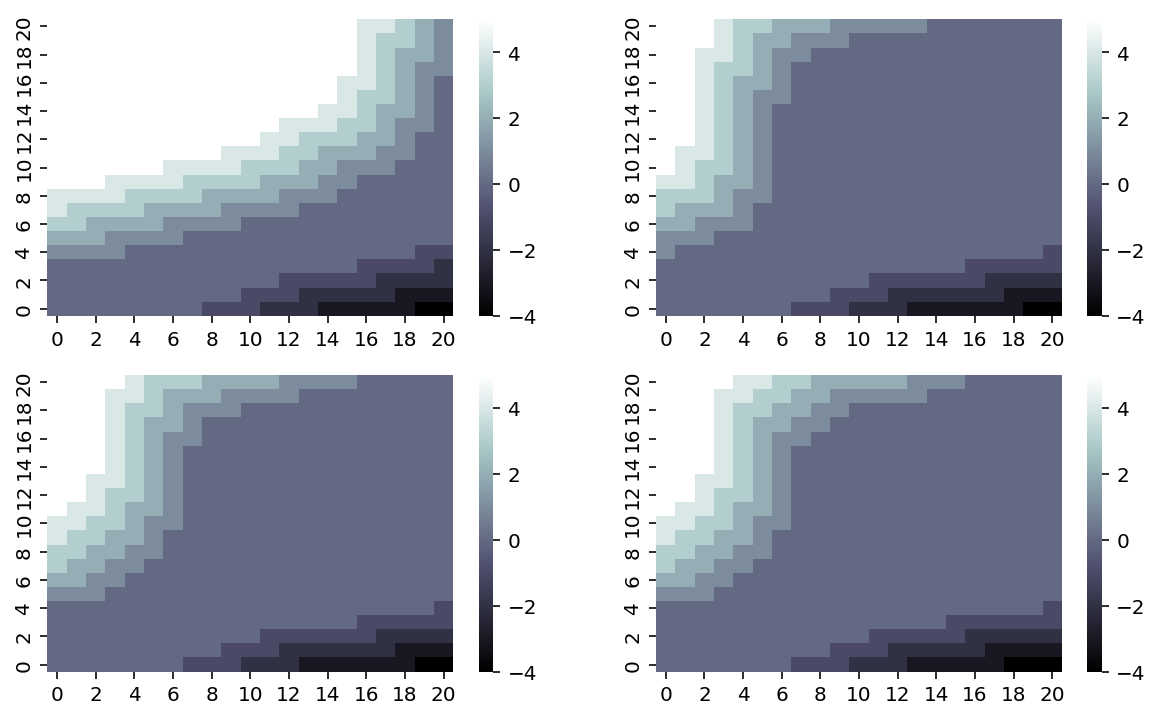

In [12]:
policy_hist = jnp.stack(policy_hist_ix, axis=0) - 5
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
ax = ax.ravel()
for axi, policy_i in zip(ax, policy_hist):
    sns.heatmap(policy_i, ax=axi, cbar=True, cmap="bone")
    axi.invert_yaxis()

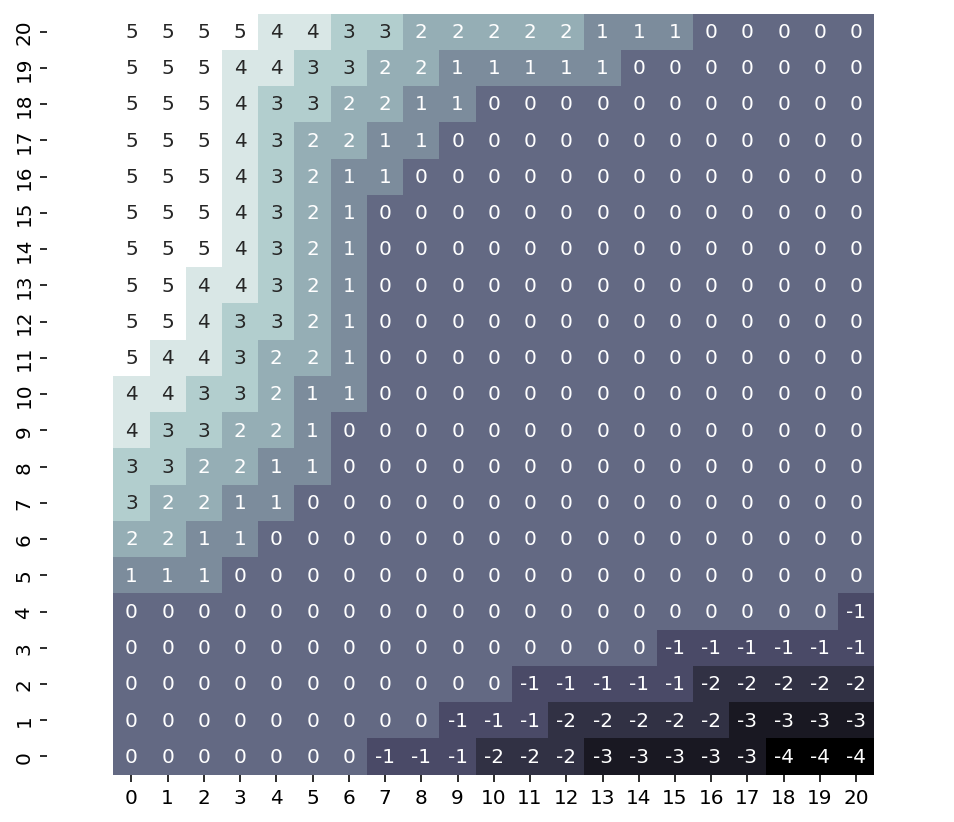

In [13]:
fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(policy_hist[-1], cmap="bone", cbar=False, ax=ax, annot=True)
ax.axis("equal")
ax.invert_yaxis()

# References

* https://towardsdatascience.com/elucidating-policy-iteration-in-reinforcement-learning-jacks-car-rental-problem-d41b34c8aec7
* https://jax.readthedocs.io/en/latest/jax.experimental.loops.html